In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../../py_utils':
    sys.path.insert(0,'../../py_utils')

import file_utils  
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Seaborn version:  0.9.0


In [2]:
summary_team_file = '../../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../../Data/D1_teams.csv'
tournament_data_file = '../../Data/tournament_results_2018.csv'
rankings_data_file = '../../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [3]:
# Do not use 2018 data for training
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [4]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [5]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [7]:
numeric_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor']

for item in numeric_features:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)

#scaler =StandardScaler()
#tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
#tourney_comp_ratings.head()

In [8]:
feature_columns = numeric_features  + ['season_t', 'top_conf_t', 'top_conf_o']

In [9]:
feature_data = tourney_comp_ratings[feature_columns].copy()
#feature_data

#### Setup feature columns for Tensorflow

In [10]:
tf_top_conf_t = tf.feature_column.numeric_column('top_conf_t')
tf_top_conf_o = tf.feature_column.numeric_column('top_conf_o')
tf_margin_victory = tf.feature_column.numeric_column('delta_margin_victory_avg')
tf_delta_fg = tf.feature_column.numeric_column('delta_fg_pct')
tf_delta_off_rebs = tf.feature_column.numeric_column('delta_off_rebs_avg')
tf_delta_def_rebs = tf.feature_column.numeric_column('delta_def_rebs_avg')
tf_delta_ft = tf.feature_column.numeric_column('delta_ft_pct')
tf_delta_to = tf.feature_column.numeric_column('delta_to_net_avg')
tf_delta_win = tf.feature_column.numeric_column('delta_win_pct')
tf_delta_off_rating = tf.feature_column.numeric_column('delta_off_rating')
tf_delta_ft_att = tf.feature_column.numeric_column('delta_ft_att_avg')
tf_delta_seed = tf.feature_column.numeric_column('delta_seed')
tf_delta_srs = tf.feature_column.numeric_column('delta_srs')
tf_delta_sos = tf.feature_column.numeric_column('delta_sos')
tf_delta_sag = tf.feature_column.numeric_column('delta_sag')
tf_delta_wlk = tf.feature_column.numeric_column('delta_wlk')
tf_delta_wol = tf.feature_column.numeric_column('delta_wol')
tf_delta_rth = tf.feature_column.numeric_column('delta_rth')
tf_delta_col = tf.feature_column.numeric_column('delta_col')
tf_delta_pom = tf.feature_column.numeric_column('delta_pom')
tf_delta_dol = tf.feature_column.numeric_column('delta_dol')
tf_delta_rpi = tf.feature_column.numeric_column('delta_rpi')
tf_delta_mor = tf.feature_column.numeric_column('delta_mor')

tf_feat_cols = [tf_margin_victory, tf_delta_fg, tf_delta_off_rebs, 
                tf_delta_def_rebs, tf_delta_ft, tf_delta_to, tf_delta_win, tf_delta_off_rating, 
                tf_delta_ft_att, tf_delta_seed, tf_delta_srs, tf_delta_sos, tf_delta_sag, 
                tf_delta_wlk, tf_delta_wol, tf_delta_rth, tf_delta_col, tf_delta_pom,
                tf_delta_dol, tf_delta_rpi, tf_delta_mor]

In [11]:
X= feature_data[feature_data['season_t']<= stop_tournament]
tourney_comp_ratings['label'] = tourney_comp_ratings.apply(lambda x: 0 if x.game_result==-1 else 1, axis=1)
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['label']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 23)
(782,)
(196, 23)
(196,)


,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,top_conf_t,top_conf_o
784,-3.0,-0.015,0.0,-1.0,0.062,2.0,-0.055,-3.232509,-1.0,3.0,-10.13,-6.65,97.0,106.0,98.0,94.0,88.0,80.0,103.0,81.0,102.0,0,1
125,8.0,0.011,-2.0,0.0,-0.039,-1.0,0.262,8.822234,-1.0,-7.0,5.32,-3.24,-24.0,-33.0,-25.0,-25.0,-28.0,-24.0,-30.0,-27.0,-19.0,0,1
236,3.0,0.022,-4.0,-3.0,0.071,-3.0,0.139,12.896390,4.0,-3.0,4.23,0.00,-11.0,-11.0,-15.0,-13.0,-14.0,-12.0,-18.0,-12.0,-14.0,0,0
719,0.0,-0.010,0.0,-2.0,-0.016,1.0,0.043,-2.544287,-4.0,0.0,-1.24,0.41,8.0,1.0,3.0,2.0,-4.0,-16.0,12.0,-14.0,-7.0,0,0
808,0.0,-0.046,5.0,2.0,-0.051,4.0,-0.008,-7.831221,1.0,-11.0,12.38,11.36,-64.0,-66.0,-58.0,-98.0,-79.0,-56.0,-78.0,-43.0,-73.0,1,0


In [13]:
scaler =StandardScaler(copy=False)

scaler.fit_transform(X_train[numeric_features])
scaler.fit_transform(X_test[numeric_features])

array([[-0.08489588, -0.11551193, -1.87207263, ..., -0.04611168,
         0.14234004, -0.08359018],
       [-1.08327148,  0.78876197,  0.37212453, ...,  0.42251962,
         0.21930183,  0.13522352],
       [ 0.24789598,  0.0519462 , -0.37594119, ..., -0.29716416,
        -0.68499919, -0.16564532],
       ...,
       [ 0.58068785, -0.68486958, -0.00190833, ...,  0.02083565,
        -0.16550711,  0.02581667],
       [ 0.41429191,  0.58781221, -0.37594119, ..., -0.09632218,
         0.02689736, -0.19299704],
       [ 1.07987564,  0.52082896, -0.37594119, ..., -0.63190081,
        -0.78120143, -0.26137632]])

#### Baseline Model

In [14]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train, batch_size=50, num_epochs=None, shuffle=True )

In [15]:
model = tf.estimator.LinearClassifier(feature_columns= tf_feat_cols, n_classes=2)
model.train(input_fn = input_func, steps=15000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\CHIPK\\AppData\\Local\\Temp\\tmpe3zbs27r', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002812987D6D8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for up

INFO:tensorflow:global_step/sec: 426.724
INFO:tensorflow:loss = 25.676826, step = 5901 (0.234 sec)
INFO:tensorflow:global_step/sec: 417.734
INFO:tensorflow:loss = 19.229433, step = 6001 (0.237 sec)
INFO:tensorflow:global_step/sec: 423.117
INFO:tensorflow:loss = 22.028957, step = 6101 (0.238 sec)
INFO:tensorflow:global_step/sec: 424.861
INFO:tensorflow:loss = 19.590595, step = 6201 (0.234 sec)
INFO:tensorflow:global_step/sec: 421.292
INFO:tensorflow:loss = 18.871384, step = 6301 (0.237 sec)
INFO:tensorflow:global_step/sec: 419.528
INFO:tensorflow:loss = 14.316312, step = 6401 (0.238 sec)
INFO:tensorflow:global_step/sec: 426.669
INFO:tensorflow:loss = 20.107012, step = 6501 (0.234 sec)
INFO:tensorflow:global_step/sec: 401.071
INFO:tensorflow:loss = 18.149776, step = 6601 (0.248 sec)
INFO:tensorflow:global_step/sec: 417.778
INFO:tensorflow:loss = 22.33464, step = 6701 (0.239 sec)
INFO:tensorflow:global_step/sec: 416.048
INFO:tensorflow:loss = 17.958218, step = 6801 (0.240 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 417.78
INFO:tensorflow:loss = 26.253315, step = 14201 (0.239 sec)
INFO:tensorflow:global_step/sec: 416.046
INFO:tensorflow:loss = 15.0797615, step = 14301 (0.241 sec)
INFO:tensorflow:global_step/sec: 414.329
INFO:tensorflow:loss = 17.031767, step = 14401 (0.241 sec)
INFO:tensorflow:global_step/sec: 432.187
INFO:tensorflow:loss = 19.98233, step = 14501 (0.232 sec)
INFO:tensorflow:global_step/sec: 432.187
INFO:tensorflow:loss = 19.018898, step = 14601 (0.230 sec)
INFO:tensorflow:global_step/sec: 410.932
INFO:tensorflow:loss = 21.664686, step = 14701 (0.242 sec)
INFO:tensorflow:global_step/sec: 421.288
INFO:tensorflow:loss = 20.924881, step = 14801 (0.237 sec)
INFO:tensorflow:global_step/sec: 401.793
INFO:tensorflow:loss = 22.088566, step = 14901 (0.249 sec)
INFO:tensorflow:Saving checkpoints for 15000 into C:\Users\CHIPK\AppData\Local\Temp\tmpe3zbs27r\model.ckpt.
INFO:tensorflow:Loss for final step: 13.808971.


In [16]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, y=y_test, batch_size=50, num_epochs=1, shuffle=False)

In [17]:
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-31-18:14:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmpe3zbs27r\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-31-18:14:20
INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.75, accuracy_baseline = 0.54591835, auc = 0.8386538, auc_precision_recall = 0.85152656, average_loss = 0.5128466, global_step = 15000, label/mean = 0.54591835, loss = 25.129482, precision = 0.77884614, prediction/mean = 0.5466426, recall = 0.7570093
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: C:\Users\CHIPK\AppData\Local\Temp\tmpe3zbs27r\model.ckpt-15000


{'accuracy': 0.75,
 'accuracy_baseline': 0.54591835,
 'auc': 0.8386538,
 'auc_precision_recall': 0.85152656,
 'average_loss': 0.5128466,
 'label/mean': 0.54591835,
 'loss': 25.129482,
 'precision': 0.77884614,
 'prediction/mean': 0.5466426,
 'recall': 0.7570093,
 'global_step': 15000}

#### Identify the predicted results for the test samples

In [18]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, batch_size=50, num_epochs=1, shuffle=False)
predictions_test = model.predict(pred_input_func)
test_predictions = list(predictions_test)
test_predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmpe3zbs27r\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([1.5146095], dtype=float32),
  'logistic': array([0.81974334], dtype=float32),
  'probabilities': array([0.18025668, 0.81974334], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([0.966622], dtype=float32),
  'logistic': array([0.7244457], dtype=float32),
  'probabilities': array([0.27555433, 0.7244457 ], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([2.7552776], dtype=float32),
  'logistic': array([0.9402107], dtype=float32),
  'probabilities': array([0.05978928, 0.9402107 ], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([1.4863186], dtype=float32),
  'logistic': array([0.81552505], dtype=float32),
  'probabilities': array([0.18447493, 0.81552505], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': arr

In [19]:
test_preds = [pred['class_ids'][0] for pred in test_predictions ]

In [20]:
y_test_df = y_test.to_frame('y_actual')
y_test_df['y_predict'] = test_preds


In [21]:
missed_predictions = y_test_df[y_test_df['y_actual'] != y_test_df['y_predict']].copy()
missed_predictions.reset_index(inplace=True)
missed_predictions.rename({"index":"sample_index"}, axis='columns', inplace=True)
missed_predictions = missed_predictions.sort_values(by=['sample_index'])
len(missed_predictions.index)

49

array([[66, 23],
       [26, 81]], dtype=int64)

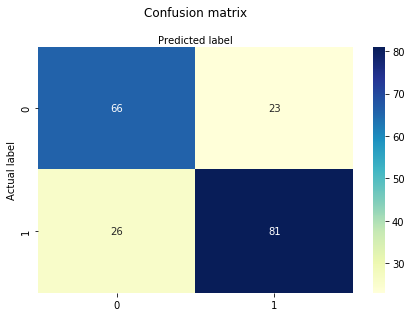

In [22]:
utils.display_confusion_matrix(y_test, test_preds)

#### Predict 2018

In [23]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year]
scaler.fit_transform(X_season[numeric_features])
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['label']
X_season.shape

(67, 24)

In [24]:
pred_2018_input_func = tf.estimator.inputs.pandas_input_fn(x=X_season, batch_size=10, num_epochs=1, shuffle=False)
predictions_2018 = model.predict(pred_2018_input_func)
pred_2018 = list(predictions_2018)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmpe3zbs27r\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [25]:
preds_2018 = [pred['class_ids'][0] for pred in pred_2018 ]
y_2018_df = y_season.to_frame('y_actual')
y_2018_df['y_predict'] = preds_2018

In [26]:
missed_2018_predictions = y_2018_df[y_2018_df['y_actual'] != y_2018_df['y_predict']].copy()

missed_2018_predictions.reset_index(inplace=True)
missed_2018_predictions.rename({"index":"sample_index"}, axis='columns', inplace=True)
missed_2018_predictions = missed_2018_predictions.sort_values(by=['sample_index'])
#len(missed_2018_predictions.index)
missed_2018_predictions

,sample_index,y_actual,y_predict
0,985,1,0
1,988,0,1
2,1004,0,1
3,1015,1,0
4,1018,0,1
5,1019,1,0
6,1021,1,0
7,1022,0,1
8,1024,0,1
9,1031,1,0


array([[27,  6],
       [ 6, 28]], dtype=int64)

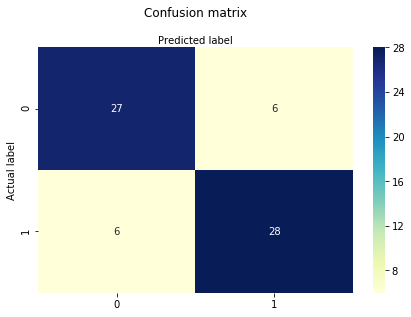

In [27]:
utils.display_confusion_matrix(y_season, preds_2018)